# Project description

Film Junky Union, a cutting-edge new community for classic movie fans, is developing a system for filtering and categorizing movie reviews. Your goal is to train a model to detect negative reviews automatically. To achieve this, you will use a dataset of IMDB movie reviews with polarity legends to build a model to classify positive and negative reviews. This must reach an F1 value of at least 0.85.

## Initialization

In [1]:
import math
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import transformers
import logging
import re
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.data.path.append('python/Proyecto 14')
nltk.download('stopwords')
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import nltk
import spacy
nlp = spacy.load('en_core_web_sm') 

[nltk_data] Downloading package punkt to /Users/tania/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tania/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tania/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tania/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tania/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tania/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#the next line provides better quality graphics on HiDPI displays
#%config InlineBackend.figure_format = 'retina'

sns.set_style()  # Apply default Seaborn styles

In [3]:
#this is to use progress_apply, you can read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load data

In [4]:
# Read the IMDb reviews data from a TSV file into a Pandas DataFrame
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
#Analyze general information
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
#generate descriptive statistics for the numerical columns in the DataFrame 
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [7]:
#Print the first rows of the Dataframe
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
#Find duplicated values 
print(df_reviews.duplicated().sum())

0


## EDA

Let's look at the number of films and reviews over the years.

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))  # Create a figure with 2 subplots arranged vertically

# 1st subplot: Number of movies released per year
ax = axs[0]  # Access the first subplot

# Count the number of movies released in each year
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()

# Fill missing years with zero counts
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)

# Plot the number of movies released per year as a bar chart
dft1.plot(kind='bar', ax=ax)

# Set the title for the first subplot
ax.set_title('Number of Movies Released per Year')

# 2nd subplot: Number of positive and negative reviews per year
ax = axs[1]  # Access the second subplot

# Count the number of positive and negative reviews for each year
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()

# Fill missing years with zero counts
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Plot the number of positive and negative reviews as stacked bars
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# Calculate the average number of reviews per movie per year
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

# Create a secondary y-axis for the average number of reviews per movie
axt = ax.twinx() 
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# Get handles and labels for the legend
lines, labels = axt.get_legend_handles_labels()

# Set the legend for both subplots
ax.legend(lines, labels, loc='upper left')

# Set the title for the second subplot
ax.set_title('Number of Reviews and Reviews per Movie Over the Years')

# Adjust the layout for better readability
fig.tight_layout()

Let's look at the distribution of the number of reviews per film with the exact counting and KDE (just to know how to differ from the exact counting)

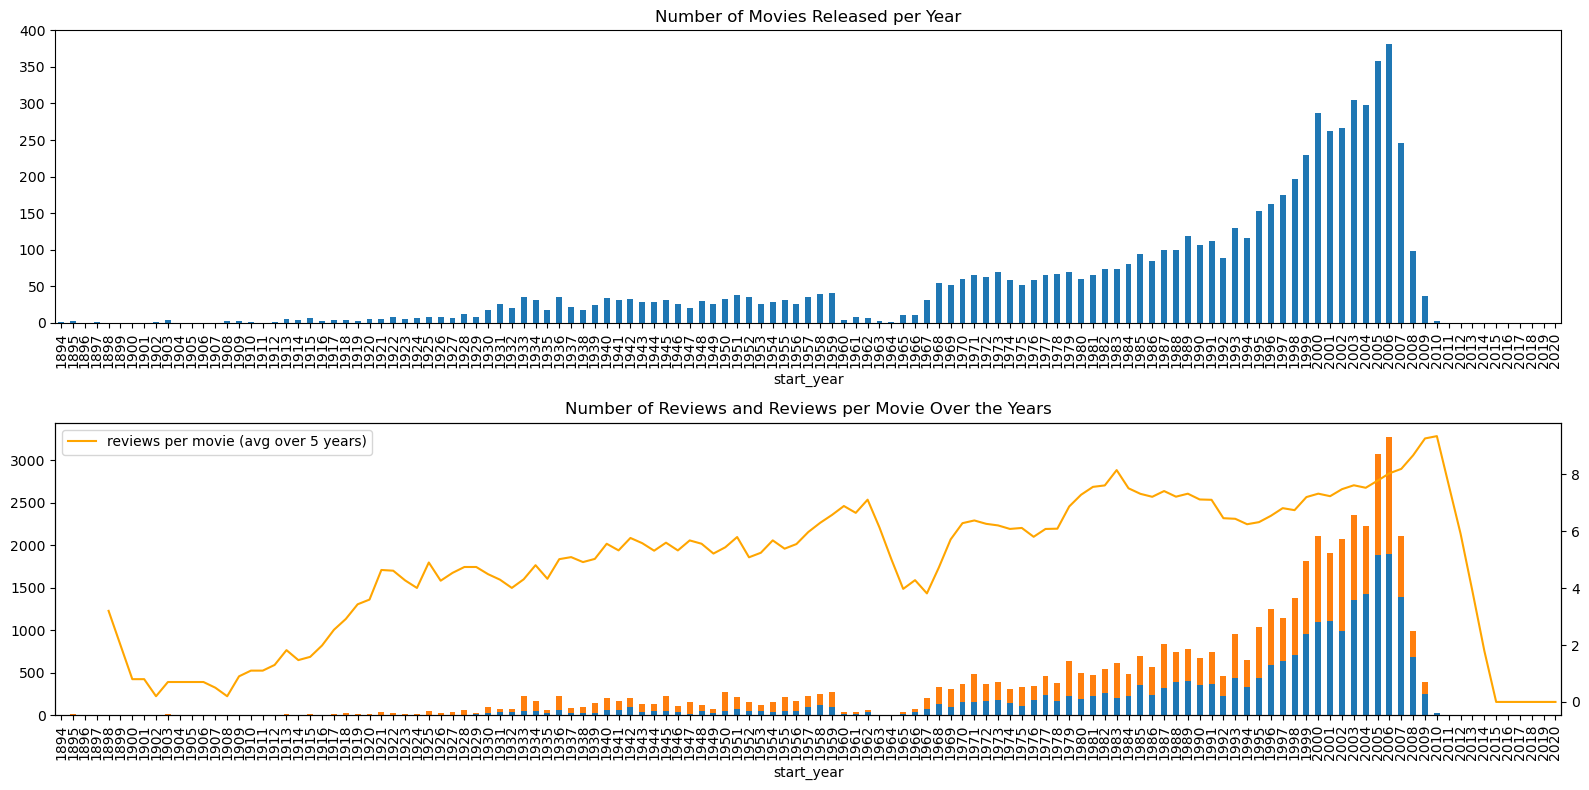

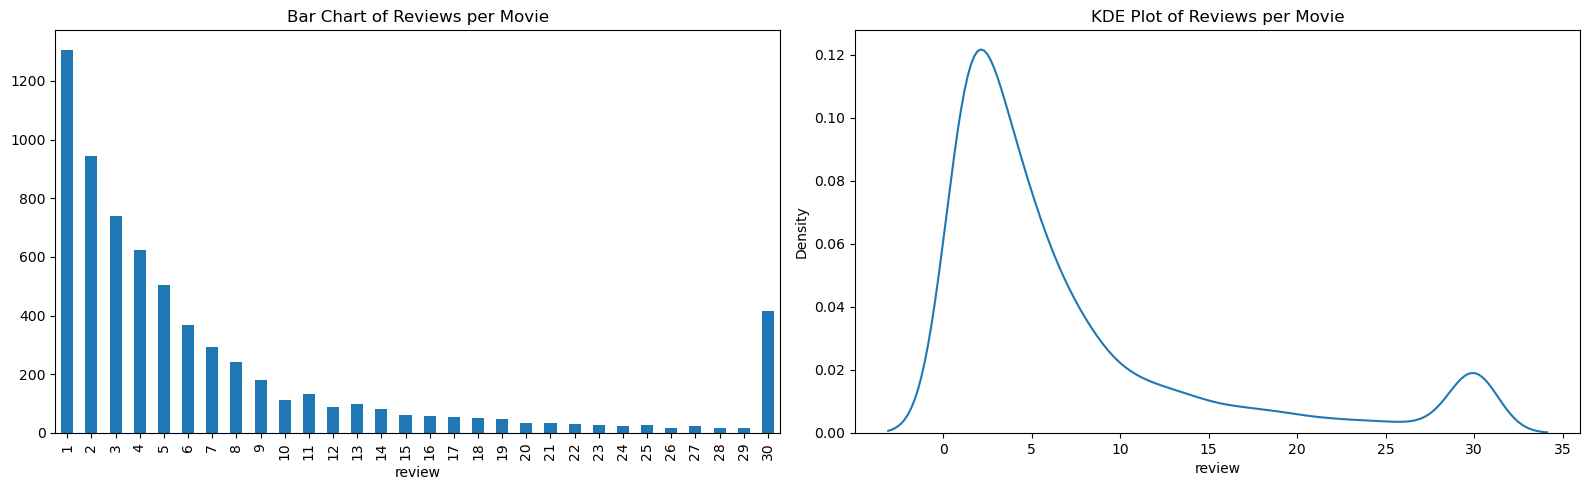

In [10]:
# Create a figure and a 1x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Bar chart for review counts
ax = axs[0]  # Select the first subplot

# Calculate review counts for each movie (tconst) and sort by frequency
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()

# Create a bar chart to visualize the review count distribution
dft.plot.bar(ax=ax)

# Set a title for the bar chart
ax.set_title('Bar Chart of Reviews per Movie')

# Subplot 2: KDE plot for review counts
ax = axs[1]  # Select the second subplot

# Calculate review counts for each movie (tconst)
dft = df_reviews.groupby('tconst')['review'].count()

# Create a KDE plot to visualize the density distribution of review counts using seaborn
sns.kdeplot(dft, ax=ax)

# Set a title for the KDE plot
ax.set_title('KDE Plot of Reviews per Movie')

# Adjust spacing between subplots to avoid overlapping elements
fig.tight_layout()

# Display the figure with subplots
plt.show()

In [11]:
#Count the values of the Pos column 
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

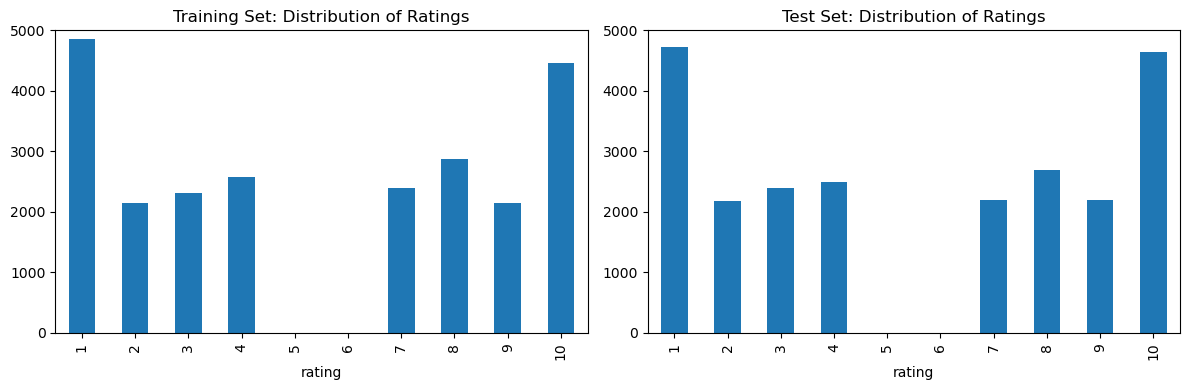

In [12]:
# Create a figure and two subplots (one for training data, one for test data)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns, figure size 12x4

# Prepare data for training set distribution plot
ax = axs[0]  # Select the first subplot (axs[0])
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()  # Count rating frequencies in training set
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)  # Ensure all ratings (1-10) are included, filling missing values with 0
dft.plot.bar(ax=ax)  # Create a bar chart to visualize rating distribution on ax

# Set limits and title for training set distribution plot
ax.set_ylim([0, 5000])  # Set y-axis limits (0 to 5000)
ax.set_title('Training Set: Distribution of Ratings')  # Set plot title

# Prepare data for test set distribution plot
ax = axs[1]  # Select the second subplot (axs[1])
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()  # Count rating frequencies in test set
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)  # Ensure all ratings (1-10) are included, filling missing values with 0
dft.plot.bar(ax=ax)  # Create a bar chart to visualize rating distribution on ax

# Set limits and title for test set distribution plot
ax.set_ylim([0, 5000])  # Set y-axis limits (0 to 5000)
ax.set_title('Test Set: Distribution of Ratings')  # Set plot title

# Adjust layout to prevent overlapping elements
fig.tight_layout()  # Adjust spacing between subplots and labels

# Display the plot
plt.show()  # You can also save the figure using plt.savefig('rating_distribution.png')

Distribution of negative and positive reviews over the years for two parts of the data set

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Top Left: Number of reviews per year and polarity (training set)
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The training set: number of reviews of different polarities per year')

# Top Right: Distribution of polarities per movie (training set)
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The training set: distribution of different polarities per film')

# Bottom Left: Number of reviews per year and polarity (test set)
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The testing set: number of reviews of different polarities per year ')

# Bottom Right: Distribution of polarities per movie (test set)
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title ('The testing set: distribution of different polarities per film')

fig.tight_layout()

/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_41447/4195113331.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_41447/4195113331.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_41447/4195113331.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ip

## Evaluation procedure

Composing an evaluation routine that can be used for all models in this project

In [14]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    This function evaluates the performance of a binary classification model on both training and test data. 
    It calculates and plots various metrics, including F1-score, ROC AUC, and Average Precision Score.

    Args:
        model: The trained classification model object.
        train_features: Features for the training data.
        train_target: True labels for the training data.
        test_features: Features for the test data.
        test_target: True labels for the test data.

    Returns:
        A pandas DataFrame containing the calculated evaluation metrics for both training and test data.
    """

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 

    for type, features, target in (('train', train_features, train_target), 
                                   ('test', test_features, test_target)):

        eval_stats[type] = {}

        # Predict probabilities for the current data
        pred_proba = model.predict_proba(features)[:, 1] 
        # Predict class labels
        pred_target = model.predict(features) 

        # Calculate F1-score for different thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Calculate ROC AUC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Calculate Average Precision Score (APS)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Plot F1-score vs. threshold
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color='blue' if type == 'train' else 'green', 
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Plot markers for specific thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-score')
        ax.legend(loc='lower center')
        ax.set_title('F1-score vs. Threshold')

        # Plot ROC curve
        ax = axs[1]
        ax.plot(fpr, tpr, color='blue' if type == 'train' else 'green', 
                label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Plot markers for specific thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Plot Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color='blue' if type == 'train' else 'green', 
                label=f'{type}, AP={aps:.2f}')
        # Plot markers for specific thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        # Calculate Accuracy and F1-score
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    # Create a DataFrame to store evaluation metrics
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2) 
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC')) 

    print(df_eval_stats)
    return df_eval_stats

## Normalization

We assume that all models below accept texts in lowercase and without digits, punctuation marks, etc.

In [15]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [16]:
def clear_text(text):
    """
    This function cleans the input text by removing all characters 
    except for letters (a-z, A-Z) and single quotes (').

    Args:
        text (str): The input text string.

    Returns:
        str: The cleaned text string.
    """

    pattern = r"[^a-zA-Z']"  # Regular expression to match any character that is not a letter or single quote
    texto = re.sub(pattern, " ", text)  # Replace all non-letter/non-quote characters with a space
    return " ".join(texto.split())  # Remove extra spaces and return the cleaned text

# Apply the clear_text function to the 'review' column of the DataFrame
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text) 

# Display the cleaned 'review_norm' column
df_reviews['review_norm']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made Presenting...
2        There is no real story the film seems more lik...
3        Um a serious film about troubled teens in Sing...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos It spo...
47327    Talk about being boring I got this expecting a...
47328    I never thought I'd say this about a biopic bu...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief This was a joy to watch I...
Name: review_norm, Length: 47331, dtype: object

## Training/test division

Fortunately, the entire data set is already divided into training/testing parts; 'ds_part' is the corresponding flag.

In [17]:
# Split data into training and testing sets based on 'ds_part' column
df_reviews_train = df_reviews.query('ds_part == "train"').copy() 
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extract the target variable ('pos') for training and testing sets
train_target_complete = df_reviews_train['pos']
test_target_complete = df_reviews_test['pos']

# Select a subset of data for training and testing 
train = df_reviews_train['review_norm'].iloc[0:201]
test = df_reviews_test['review_norm'].iloc[0:201]

# Select the corresponding target variables for the subset
train_target = train_target_complete.iloc[0:201]
test_target = test_target_complete.iloc[0:201]

# Print the shapes of the training and testing sets
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Work with models

### Model 0 -Constant

In [18]:
# Create a dummy classifier that predicts the most frequent class
model = DummyClassifier(strategy="most_frequent")

# Train the dummy classifier on the training data
model.fit(train, train_target)

# Make predictions on the test data using the dummy classifier
dummy_predict = model.predict(test)

# Calculate F1-score to evaluate the dummy classifier's performance
f1 = f1_score(test_target, dummy_predict)

# Print the F1-score of the dummy classifier
print("F1-score of the constant model:", f1)


F1-score of the constant model: 0.0


### Modelo 1 -NLTK, TF-IDF y LR

TF-IDF

In [19]:
#Creates an object called lemmatizer that will be used to find the base forms of words in the text data
lemmatizer  = WordNetLemmatizer()

In [20]:
# Select the first 201 rows from the 'review_norm' column in the training and testing DataFrames
train1 = df_reviews_train['review_norm'].iloc[0:201]
test1 = df_reviews_test['review_norm'].iloc[0:201]

In [21]:

# Convert the training and test data to lowercase
tokens_train1 = train1.str.lower() 
tokens_test1 = test1.str.lower() 

# Tokenize the training and test data into individual words
tokens_train1 = tokens_train1.apply(word_tokenize) 
tokens_test1 = test1.str.lower().apply(word_tokenize)

In [22]:
def lemmatize_tokens(token_list):
    """
    Lemmatizes a list of tokens using a given lemmatizer.

    Args:
        token_list: A list of tokens (words) to be lemmatized.

    Returns:
        str: A string containing the lemmatized tokens joined by spaces.
    """
    lemmas = []
    for token in token_list:
        lemma = lemmatizer.lemmatize(token)  # Lemmatize the current token
        lemmas.append(lemma)                # Append the lemma to the list
    return ' '.join(lemmas)                  # Join the list of lemmas into a single string

# Apply the lemmatization function to the training data
train['lemmas1'] = tokens_train1.apply(lemmatize_tokens) 

# Apply the lemmatization function to the test data
test['lemmas1'] = tokens_test1.apply(lemmatize_tokens)

In [23]:
print(train['lemmas1'])

0      the pakage implies that warren beatty and gold...
1      how the hell did they get this made presenting...
7      this true story of carlson 's raider is more o...
8      should have been titled 'balderdash ' little i...
9      the movie 'gung ho ' the story of carlson 's m...
                             ...                        
352    the movie start quite with an intriguing scene...
353    this is the perfect example of something great...
354    the worst movie i have seen in quite a while i...
355    the russian movie follows the life of three no...
356    i saw the film at the belgrade film festival l...
Name: review_norm, Length: 201, dtype: object


In [24]:
# Vectorization

stop_words = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) #Calculates TF-IDF values ​​for a set of texts. The IDF measures the importance of a word in the set of documents.
#The words that appear in many documents will have a low IDF, while the words that appear in a few documents will have a high IDF.
train_tf_idf1 = count_tf_idf.fit_transform(train['lemmas1'])
test_tf_idf1 = count_tf_idf.transform(test['lemmas1'])

print('Train TF-IDF shape:', train_tf_idf1.shape)
print('Test TF-IDF shape:', test_tf_idf1.shape)

# Access the first element

#Data: Contains non -null values.
#indices: Contains the indices of the columns corresponding to the values ​​in data.
#indpt: contains pointers at the beginning of each row in data and indices.

data = test_tf_idf1.data
indices = test_tf_idf1.indices
indptr = test_tf_idf1.indptr

first_element = data[indptr[0]:indptr[1]]
print(first_element)

Train TF-IDF shape: (201, 5508)
Test TF-IDF shape: (201, 5508)
[0.13206308 0.11449202 0.06125616 0.1860266  0.14234149 0.08664256
 0.14234149 0.11449202 0.11911382 0.07934991 0.09692097 0.09912668
 0.09489191 0.10719938 0.15088448 0.10421362 0.19825336 0.17618301
 0.07127721 0.08809151 0.13206308 0.11911382 0.09692097 0.11628993
 0.11911382 0.05150044 0.14234149 0.12477043 0.10897241 0.0439451
 0.13206308 0.08664256 0.10719938 0.12477043 0.13206308 0.0839717
 0.08042878 0.09489191 0.13206308 0.04641351 0.15464171 0.07732085
 0.13206308 0.06398456 0.09489191 0.08809151 0.05654829 0.09126435
 0.06978562 0.12477043 0.12477043 0.14234149 0.06978562 0.11449202
 0.09126435 0.11911382 0.07732085 0.09912668 0.14234149 0.10154276
 0.05185499 0.11449202 0.09692097 0.14234149 0.23822763 0.13206308
 0.11449202 0.09912668 0.05488542 0.28468298 0.10421362]


In [25]:
# Create a Logistic Regression model with specified parameters
model = LogisticRegression(random_state=54321, solver='liblinear')

# Train the model on the training TF-IDF features and target labels
model.fit(train_tf_idf1, train_target)

# Use the trained model to make predictions on the test TF-IDF features
pred_test = model.predict(test_tf_idf1)

In [26]:
# Call the 'evaluate_model' function to assess the performance of the given model 
evaluate_model(model, train_tf_idf1, train_target, test_tf_idf1, test_target)

          train  test
Accuracy   0.93  0.47
F1         0.89  0.00
APS        1.00  0.85
ROC AUC    1.00  0.84


,train,test
Accuracy,0.93,0.47
F1,0.89,0.00
APS,1.00,0.85
ROC AUC,1.00,0.84


### Modelo 3 -spaCy, TF-IDF y LR

In [27]:
# Select the first 201 elements from the 'review_norm' column of both training and test DataFrames
train3 = df_reviews_train['review_norm'].iloc[0:201]
test3 = df_reviews_test['review_norm'].iloc[0:201]

In [28]:
# Load the spaCy language model, disabling parser and NER for faster processing
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

# Define a function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    """
    Lemmatizes a list of tokens using the spaCy model.

    Args:
        tokens (str): A string containing the tokens.

    Returns:
        str: A string containing the lemmatized tokens.
    """
    doc = nlp(tokens.lower())  # Process the tokens with the spaCy model, converting to lowercase
    lemmas = [token.lemma_ for token in doc]  # Extract the lemma (base form) of each token
    return ' '.join(lemmas)  # Join the lemmatized tokens back into a single string

# Apply the lemmatization function to the 'review_norm' column in the training and test sets
train3['lemmas'] = train3.apply(lemmatize_tokens)
test3['lemmas'] = test3.apply(lemmatize_tokens)

# Print an example of the original and lemmatized text
print('Original text:', df_reviews_train['review_norm'].iloc[2])
print()
print('Lemmatized text:', train3['lemmas'].iloc[2])

Original text: This true story of Carlson's Raiders is more of a Army training film than anything else Obviously thrown together quickly on a miniscule budget about the only thing it has to recommend it is an early performance by Robert Mitchum who's the only decent actor in the cast and actual footage of the wreckage at Pearl Harbor which gets your blood boiling as it was obviously intended to do

Lemmatized text: this true story of carlson 's raider be more of a army training film than anything else obviously throw together quickly on a miniscule budget about the only thing it have to recommend it be an early performance by robert mitchum who be the only decent actor in the cast and actual footage of the wreckage at pearl harbor which get your blood boil as it be obviously intend to do


In [29]:
# Vectorization
stop_words = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf3 = count_tf_idf.fit_transform(train3['lemmas'])
test_tf_idf3 = count_tf_idf.transform(test3['lemmas'])

print('Train TF-IDF shape:', train_tf_idf3.shape)
print('Test TF-IDF shape:', test_tf_idf3.shape)

# Access the first element
data = test_tf_idf3.data
indices = test_tf_idf3.indices
indptr = test_tf_idf3.indptr

first_element = data[indptr[0]:indptr[1]]
print(first_element)

Train TF-IDF shape: (201, 4863)
Test TF-IDF shape: (201, 4863)
[0.13402876 0.11619616 0.18879548 0.12662756 0.08396634 0.14446015
 0.11619616 0.12088675 0.08053098 0.09836357 0.09439774 0.09630432
 0.10879497 0.10576477 0.20120423 0.17880538 0.07233813 0.08940269
 0.13402876 0.11619616 0.09630432 0.15649995 0.05226699 0.14446015
 0.12662756 0.09660232 0.12662756 0.08654119 0.10060211 0.12662756
 0.13402876 0.08396634 0.08162591 0.10060211 0.13402876 0.04540744
 0.15694345 0.07847172 0.13402876 0.06493693 0.09630432 0.08940269
 0.05738998 0.09262276 0.06216792 0.12662756 0.12662756 0.14446015
 0.07082434 0.11223033 0.08053098 0.12088675 0.06493693 0.14446015
 0.10060211 0.14446015 0.10305416 0.05262682 0.11619616 0.09630432
 0.14446015 0.2417735  0.13402876 0.11619616 0.10060211 0.09027039
 0.2889203  0.09836357]


In [30]:
# Create a LogisticRegression model with random state for reproducibility
model3 = LogisticRegression(random_state=54321, solver='liblinear')

# Train the LogisticRegression model on the TF-IDF features and target labels
model3.fit(train_tf_idf3, train_target)

# Make predictions on the test data using the trained LogisticRegression model
pred_test = model3.predict(test_tf_idf3)

In [31]:
# Evaluate the performance of the given model 
evaluate_model(model3, train_tf_idf3, train_target, test_tf_idf3, test_target)

          train  test
Accuracy   0.93  0.47
F1         0.89  0.00
APS        1.00  0.87
ROC AUC    1.00  0.85


,train,test
Accuracy,0.93,0.47
F1,0.89,0.00
APS,1.00,0.87
ROC AUC,1.00,0.85


### Modelo 4 -spaCy, TF-IDF y LGBMClassifier

In [32]:
from lightgbm import LGBMClassifier

In [33]:
# Create a LightGBM classifier
model4 = LGBMClassifier()  

In [ ]:
# Fit the model to the training data (TF-IDF features)
model4.fit(train_tf_idf3, train_target)
print("Modelo entrenado exitosamente")

In [34]:
# Make predictions on the test data using the fitted model
pred_test = model4.predict(test_tf_idf1)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

In [ ]:
# Evaluate the performance of the model
evaluate_model(model4, train_tf_idf3, train_target, test_tf_idf3, test_target)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

### Model 9 -BERT

In [ ]:
import torch
import transformers
from transformers import BertConfig, BertModel

In [ ]:
# Select the first 10 reviews from the training set
train9 = df_reviews_train['review_norm'].iloc[0:10] 

# Select the first 10 reviews from the test set
test9 = df_reviews_test['review_norm'].iloc[0:10]

In [ ]:
# Load the pre-trained BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') 

# Load the pre-trained BERT configuration 
config = transformers.BertConfig.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    """
    This function converts a list of text strings into BERT embeddings.

    Args:
        texts (List[str]): A list of text strings to convert to embeddings.
        max_length (int, optional): The maximum length of the tokenized text. Defaults to 512.
        batch_size (int, optional): The batch size for processing the text. Defaults to 100.
        force_device (str, optional): Force the device to use (e.g., 'cpu' or 'cuda'). Defaults to None.
        disable_progress_bar (bool, optional): Disable the progress bar during processing. Defaults to False.

    Returns:
        numpy.ndarray: A NumPy array containing the BERT embeddings for the input texts.
    """

    ids_list = []
    attention_mask_list = []
    max_length = 10  # Override the default max_length here (update if needed)

    # Convert text to token IDs and attention masks
    for text in texts:
        encoded_text = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=512)
        ids_list.append(encoded_text)

    # Create attention masks (0 for padding tokens, 1 for real tokens)
    for ids in ids_list:
        padded_ids = np.array(ids[:max_length] + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded_ids != 0, 1, 0)
        attention_mask_list.append(attention_mask)

    # Determine device to use (GPU or CPU)
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {device}')

    # Move the model to the chosen device
    model.to(device)

    # Print device usage information (unless progress bar is disabled)
    if not disable_progress_bar:
        print(f'Using device {device}.')

    # Find the maximum sequence length in the batch
    max_length = max(len(ids) for ids in ids_list)

    # Pad sequences to the same length
    padded_ids_list_train = [ids + [0] * (max_length - len(ids)) for ids in ids_list]

    # Create an empty list to store the embeddings
    embeddings = []

    # Process the text in batches
    for i in tqdm(range(math.ceil(len(padded_ids_list_train) / batch_size)), disable=disable_progress_bar):
        # Get a batch of token IDs and attention masks
        ids_batch = torch.LongTensor(padded_ids_list_train[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)

        # Set model to evaluation mode (disable dropout layers)
        with torch.no_grad():
            model.eval()

        # Get the embeddings for the current batch
        batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # Extract the first token embedding from each sequence in the batch
        # and convert it back to NumPy arraydef BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    """
    This function converts a list of text strings into BERT embeddings.

    Args:
        texts (List[str]): A list of text strings to convert to embeddings.
        max_length (int, optional): The maximum length of the tokenized text. Defaults to 512.
        batch_size (int, optional): The batch size for processing the text. Defaults to 100.
        force_device (str, optional): Force the device to use (e.g., 'cpu' or 'cuda'). Defaults to None.
        disable_progress_bar (bool, optional): Disable the progress bar during processing. Defaults to False.

    Returns:
        numpy.ndarray: A NumPy array containing the BERT embeddings for the input texts.
    """

    ids_list = []
    attention_mask_list = []
    max_length = 10  # Override the default max_length here (update if needed)

    # Convert text to token IDs and attention masks
    for text in texts:
        encoded_text = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=512)
        ids_list.append(encoded_text)

    # Create attention masks (0 for padding tokens, 1 for real tokens)
    for ids in ids_list:
        padded_ids = np.array(ids[:max_length] + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded_ids != 0, 1, 0)
        attention_mask_list.append(attention_mask)

    # Determine device to use (GPU or CPU)
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {device}')

    # Move the model to the chosen device
    model.to(device)

    # Print device usage information (unless progress bar is disabled)
    if not disable_progress_bar:
        print(f'Using device {device}.')

    # Find the maximum sequence length in the batch
    max_length = max(len(ids) for ids in ids_list)

    # Pad sequences to the same length
    padded_ids_list_train = [ids + [0] * (max_length - len(ids)) for ids in ids_list]

    # Create an empty list to store the embeddings
    embeddings = []

    # Process the text in batches
    for i in tqdm(range(math.ceil(len(padded_ids_list_train) / batch_size)), disable=disable_progress_bar):
        # Get a batch of token IDs and attention masks
        ids_batch = torch.LongTensor(padded_ids_list_train[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)

        # Set model to evaluation mode (disable dropout layers)
        with torch.no_grad():
            model.eval()

        # Get the embeddings for the current batch
        batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # Extract the first token embedding from each sequence in the batch
        # and convert it back to NumPy array
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    # Concatenate the embeddings from all batches
    return np.concatenate(embeddings)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    # Concatenate the embeddings from all batches
    return np.concatenate(embeddings)

In [ ]:
#Attention! Bert's execution for thousands of texts can take a long time on the CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(train9, force_device='cpu')

In [ ]:
test_features_9 = BERT_text_to_embeddings(test9, force_device='cpu')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
evaluate_model(model3, train_tf_idf3, train_target, test_tf_idf3, test_target)

## My reviews

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
'Launching on Netflix was a brave move & i Really Appreciate Being Uble to Binge on Episode After Episode, of this exciting intelligent new drama.'
], columns = ['review'])

""
my_reviews = pd.dataframe ([[
    'I just didn't like it, it's not my kind of movie.'
    'Well, I was bored and I fell asleep in half movie.'
    'I was really fascinated with the movie',
'Even the actors seemed very old and disinterested, and they were paid to be in the film. What a heartless robbery.',
    'I didn't expect the re-release to be so good! The writers really cared about the source material,'
    'The film had its ups and downs, but I feel that overall it is a decent film. Yes I would see her again',
'What a lousy attempt at comedy. Not a single joke makes sense, everyone acts irritating and loud, not even kids will like this!',
    'It was very brave to launch on Netflix and I really appreciate being able to continue watching episode after episode of this exciting and intelligent new drama.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

### Model 2

In [ ]:
# Extract the 'review_norm' column from the my_reviews DataFrame
texts = my_reviews['review_norm'] 

# Predict the probability of positive sentiment for each review using the trained model
my_reviews_pred_prob = model.predict_proba(count_tf_idf.transform(texts))[:, 1] 

# Iterate through the reviews and print the predicted probability and a snippet of the review
for i, review in enumerate(texts.str.slice(0, 100)): 
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
# Extract the 'review_norm' column from the DataFrame 
texts = my_reviews['review_norm'] 

# Predict probabilities for each text using the trained model
my_reviews_pred_prob = model3.predict_proba(count_tf_idf.transform(texts.apply(lambda x: lemmatize_tokens(x))))[:, 1] 

# Iterate through the texts and print the predicted probability and a snippet of each review
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
# Extract the normalized reviews from the DataFrame
texts = my_reviews['review_norm'] 

# Use the pre-trained TF-IDF vectorizer to transform the normalized reviews
tfidf_vectorizer_4 = count_tf_idf  # Assuming count_tf_idf is a pre-trained TF-IDF vectorizer object
my_reviews_pred_prob = model4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: lemmatize_tokens(x))))[:, 1]

# Iterate through the reviews and print predicted probabilities
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
# Extract the normalized reviews from the DataFrame
texts = my_reviews['review_norm'] 

# Generate embeddings for the reviews using the BERT model
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True) 

# Get prediction probabilities from the trained model 
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1] 

# Print the predicted probability and a snippet of each review
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions


This project implemented a feelings classification system for films reviews, with the aim of automatically identifying negative reviews. Several classification models were trained, including traditional models such as logistics regression and gradient strengthening, as well as more advanced Bert models. However, challenges such as overjuste and problems with Bert's burden were found. Despite these obstacles, exploratory analysis of the data were carried out and various hyperparameters prepr Marketing and adjustment techniques were implemented to improve the performance of the models.
The models exhibit high performance on the training set (F1, APS and ROC AUC close to 1), but their performance on the test set is significantly lower, especially in terms of F1-score. This suggests severe overfitting in the models. 
Models 3, 4 and 1, despite having good results on the training set, obtain a very low F1-score on the test set, which indicates a generalization problem.